# Compute seasonal net outgassing of O2 and APO

Start with [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) magic; this reloads modules automatically before entering the execution of code and thus enabled development in modules like [util.py](util.py).

In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import os

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import util

import intake

## Connect to catalog

This notebook uses an [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) to describe file locations. This is the basis of [intake-esm](https://intake-esm.readthedocs.io/en/latest/), though here we are not using `intake-esm` directly.

In [58]:
cat = intake.open_esm_datastore(util.catalog_json)
cat

,unique
activity_id,17
institution_id,34
source_id,74
experiment_id,127
member_id,399
table_id,35
variable_id,1064
grid_label,12
dcpp_init_year,59
version,500


In [59]:
%%time
df = pd.read_csv(util.catalog_csv)
df

CPU times: user 5.9 s, sys: 2.04 s, total: 7.93 s
Wall time: 8.1 s


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
0,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r1i1p1f1,day,rsds,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
1,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r1i1p1f1,day,tasmax,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
2,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r2i1p1f1,day,rsds,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
3,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r2i1p1f1,day,tasmax,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
4,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r3i1p1f1,day,rsds,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
...,...,...,...,...,...,...,...,...,...,...,...,...
1850252,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,6hrLev,va,gn,NaN,v20200602,209901010600-210001010000,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...
1850253,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,6hrLev,va,gn,NaN,v20200602,210001010600-210101010000,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...
1850254,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Oday,tos,gn,NaN,v20190726,20150101-20491230,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...
1850255,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Oday,tos,gn,NaN,v20190726,20500101-20991230,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...


## Specify a subset of models

In [60]:
models = [
    'CanESM5',
    'CanESM5-CanOE', 
    'CNRM-ESM2-1', 
    'ACCESS-ESM1-5',  
    'MPI-ESM-1-2-HAM', 
    'IPSL-CM6A-LR',
    'MPI-ESM1-2-HR',
    'MPI-ESM1-2-LR',  
    'NorCPM1', # not plotting bc no areacello
    'NorESM2-LM', 
    'UKESM1-0-LL',
    'MIROC-ES2L', 
    'MRI-ESM2-0',
    'CESM2', # no fgo2 but adding to compare CO2
]
## others on ESGF showing historical+Omon+fgo2 = EC-Earth3-CC, GFDL-CM4, GFDL-ESM4, IPSL-CM5A2-INCA, IPSL-CM6A-LR-INCA, NorESM2-MM (but of the above ESGF not showing CNRM-ESM2-1, UKESM1-0-LL, MIROC-ES2L, MRI-ESM2-0)


### Test read single model

In [61]:
source_id = 'UKESM1-0-LL'
variable_id = ['sos']
time_slice = slice('2005', '2014')
experiment_id = 'historical' 
nmax_members = 4

dsi = util.open_cmip_dataset(
    source_id=source_id, 
    variable_id=variable_id, 
    experiment_id=experiment_id, 
    time_slice=time_slice, 
    table_id='Omon',
    nmax_members=nmax_members,
)
dsi

UKESM1-0-LL, historical, ['sos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 6 ensemble members


<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 330, member_id: 4, time: 120, vertices: 4)
Coordinates:
  * time                (time) object 2005-01-16 00:00:00 ... 2014-12-16 00:0...
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    latitude            (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
  * member_id           (member_id) <U8 'r1i1p1f2' 'r2i1p1f2' ... 'r4i1p1f2'
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    sos                 (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
Attributes: (12/43)
    experiment_id:           historical
    parent_mip_era:          CMIP6
    parent_source_id:        UKESM1-0-LL
    mip_era:                 CMIP6
    cmor_version:            3.4.0
    data_specs_version:      01.00.29
    ...                      ...
    variable_id:             sos
    sub_experiment:          none
    grid_label:              gn
    cv_version:              6.2.20.1
    history:                 2019-06-24T12:18:13Z ; CMOR rewrote data to be c...
    intake_esm_dataset_key:  CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn

### Test calculating derived variables

In [62]:
source_id = 'UKESM1-0-LL'
#variable_name = 'fgn2:sos,tos,hfds'
#variable_name = 'fgo2_thermal:sos,tos,hfds'
variable_name = 'fgapo:fgo2,fgco2,sos,tos,hfds'
time_slice = slice('2005', '2014')
experiment_id = 'historical' 
nmax_members = 4

print(variable_name)
variable_id = variable_name
derived_var = variable_name
if ':' in variable_id:
    variable_id = variable_name.split(':')[-1].split(',')
    derived_var = variable_name.split(':')[0]        
    print(variable_id)
    print(derived_var)
                
dsi = util.open_cmip_dataset(
    source_id=source_id, 
    variable_id=variable_id, 
    experiment_id=experiment_id, 
    time_slice=time_slice, 
    table_id='Omon',
    nmax_members=nmax_members,
)

# compute derived variables
if derived_var == 'fgn2':
    dsi = util.compute_fgn2(dsi)

elif derived_var == 'fgo2_thermal':
    dsi = util.compute_fgo2_thermal(dsi)

elif derived_var == 'fgapo':
    o2scale = -1.0 if source_id in models_flipsign['fgo2'] else 1.0 # needed here bc NorESM2-LM O2 is flipped
    co2scale = -1.0 if source_id in models_flipsign['fgco2'] else 1.0
    n2scale = -1.0 if source_id in models_flipsign['fgn2'] else 1.0
    dsi = util.compute_fgapo(dsi,o2scale,co2scale,n2scale)
    
dsi

fgapo:fgo2,fgco2,sos,tos,hfds
['fgo2', 'fgco2', 'sos', 'tos', 'hfds']
fgapo
UKESM1-0-LL, historical, ['fgo2', 'fgco2', 'sos', 'tos', 'hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 16 ensemble members


<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 330, member_id: 4, time: 120, vertices: 4)
Coordinates:
  * member_id           (member_id) <U9 'r1i1p1f2' 'r2i1p1f2' ... 'r4i1p1f2'
  * time                (time) object 2005-01-16 00:00:00 ... 2014-12-16 00:0...
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    latitude            (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    depth               float64 0.0
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    fgco2               (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
    fgo2                (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
    hfds                (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
    sos                 (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
    tos                 (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
    fgn2                (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
    fgapo               (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
Attributes: (12/45)
    experiment_id:           historical
    parent_mip_era:          CMIP6
    parent_source_id:        UKESM1-0-LL
    mip_era:                 CMIP6
    cmor_version:            3.4.0
    data_specs_version:      01.00.29
    ...                      ...
    variable_id:             tos
    branch_time_in_parent:   156600.0
    sub_experiment:          none
    grid_label:              gn
    history:                 2019-12-05T11:36:40Z ; CMOR rewrote data to be c...
    intake_esm_dataset_key:  CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn

## Get grid data from each model

Skip models where the grid data is not available

In [63]:
dsets_fix = {}
grid_variables = ['areacello',]
for model in models:
    dsets_m = [util.get_gridvar(df, model, v) for v in grid_variables]
    dsets_m = [ds for ds in dsets_m if ds is not None]
    if dsets_m:
        dsets_fix[model] = xr.merge(dsets_m)
        dsets_fix[model].attrs['source_id'] = model
        
list(dsets_fix.keys())

NorCPM1: missing "areacello"


/glade/u/home/stephens/.conda/envs/sno/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


['CanESM5',
 'CanESM5-CanOE',
 'CNRM-ESM2-1',
 'ACCESS-ESM1-5',
 'MPI-ESM-1-2-HAM',
 'IPSL-CM6A-LR',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'NorESM2-LM',
 'UKESM1-0-LL',
 'MIROC-ES2L',
 'MRI-ESM2-0',
 'CESM2']

## Compute a region mask for integration

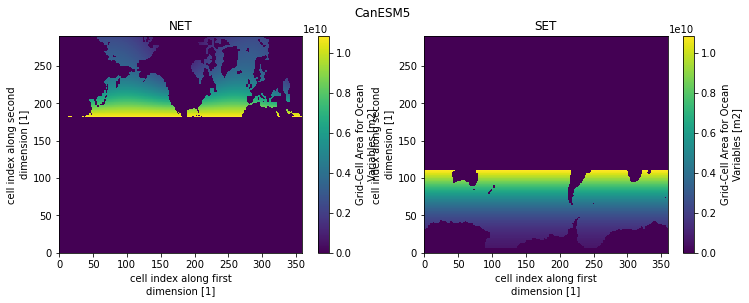

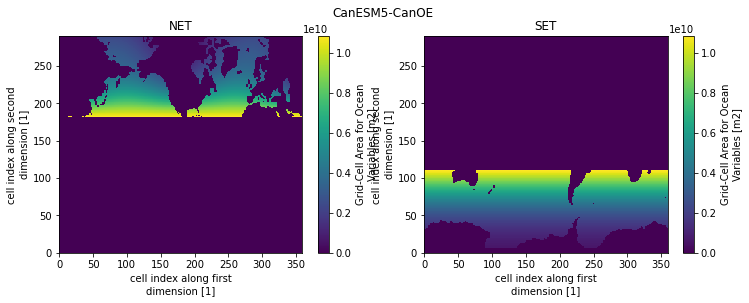

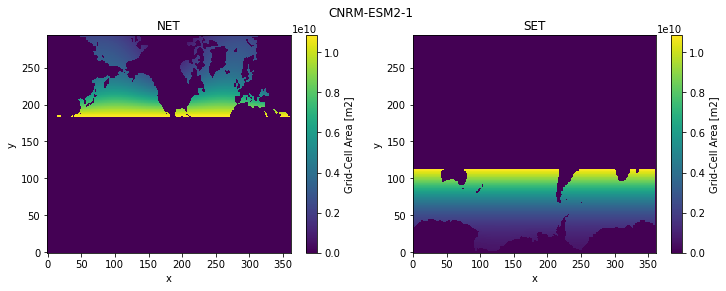

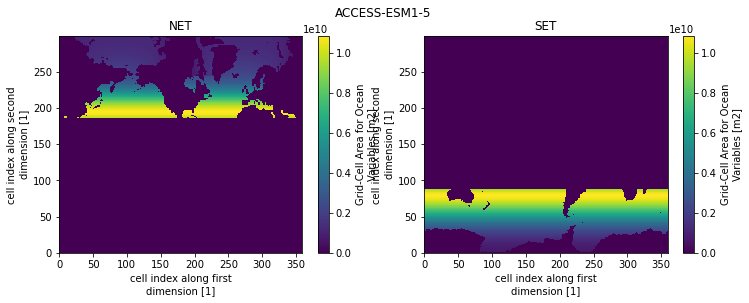

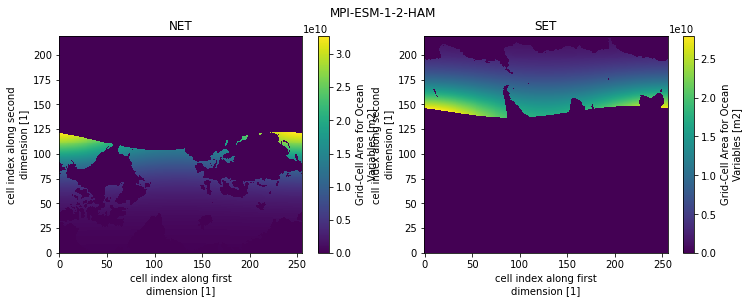

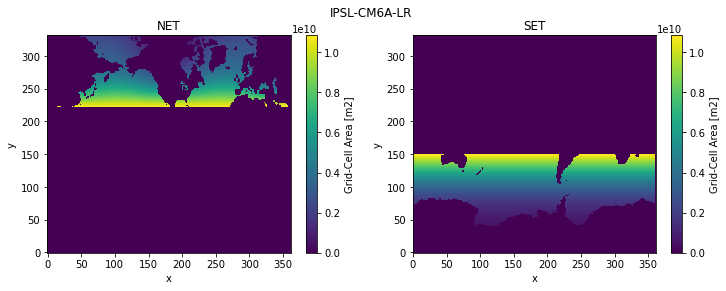

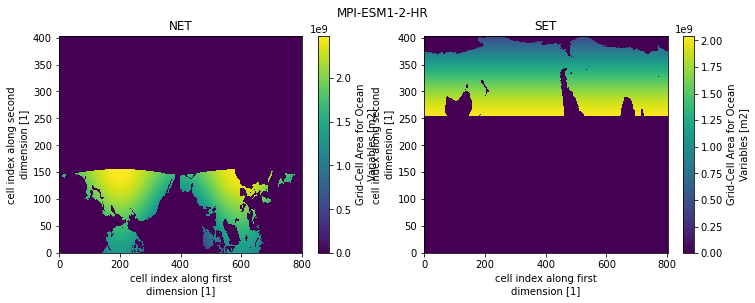

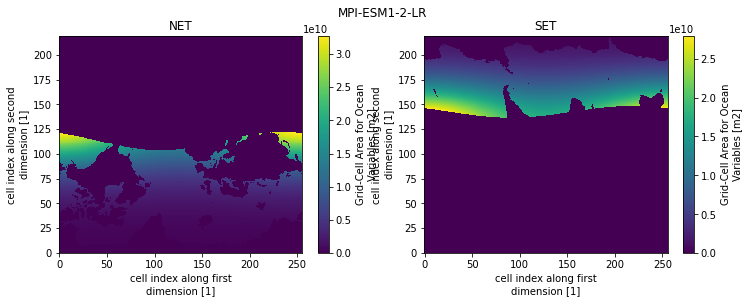

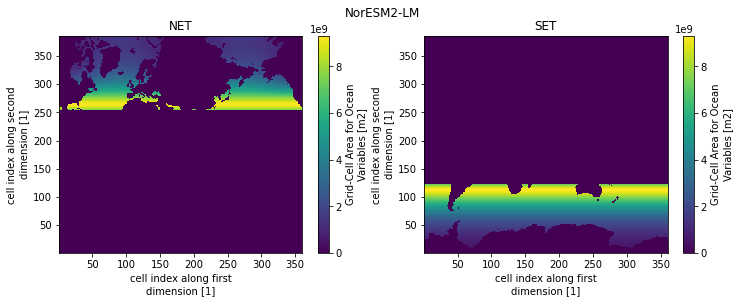

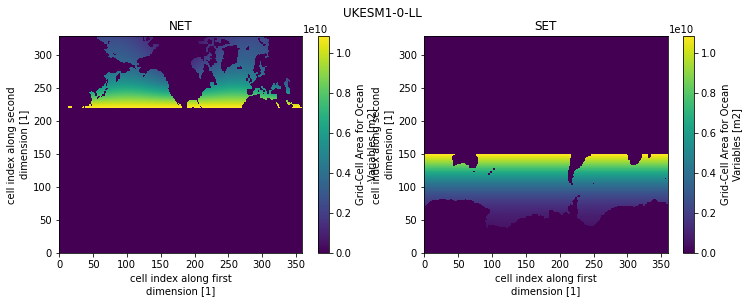

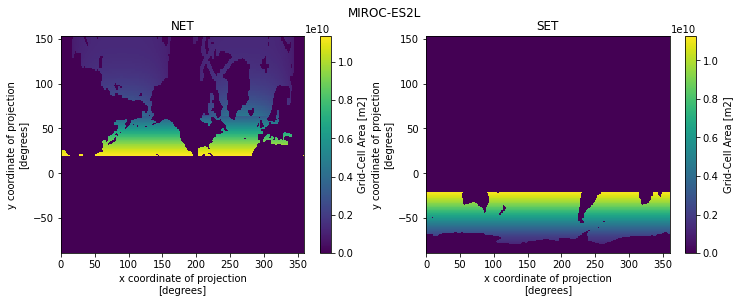

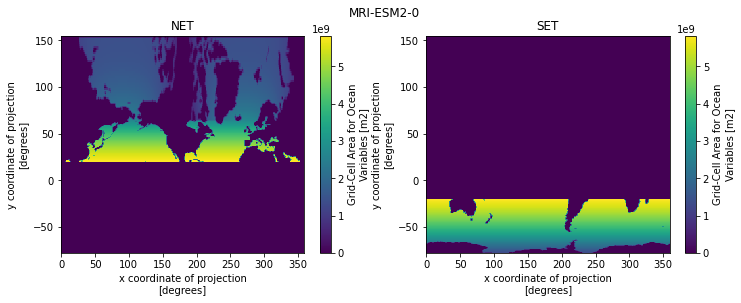

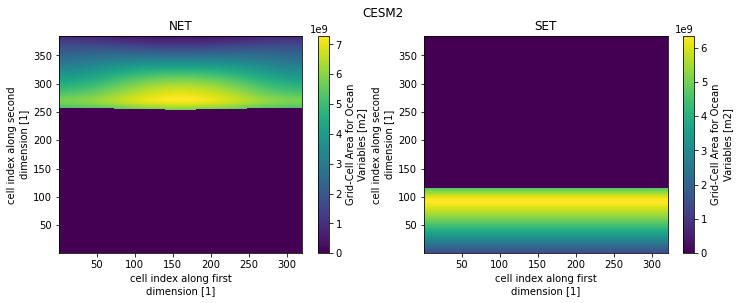

In [64]:
rmask_definition = 'SET_NET' # poleward of 20
#rmask_definition = 'SHL_NHL' # poleward of 45
#rmask_definition = 'global' ### grid-cell area is maxing at 20 degrees in each hemisphere

rmask_dict = {}
for model in models:    
    if model not in dsets_fix:
        continue
    rmask_dict[model] = util.get_rmask_dict(
        dsets_fix[model], 
        mask_definition=rmask_definition, 
        plot=True
    )    

## Assemble monthly-mean climatology

This code takes the following steps:
- Read a dataset for each model
- Compute the regional integral 
- Compute the mean for each month and average across ensemble members
- Concatenate the resulting timeseries along a `source_id` dimension

Note that the code is set up to cache the resulting dataset; it will optionally read this dataset, rather than recreate it, if it exists.

In [101]:
%%time
variable_ids = [
    'intpp', 
    'fgco2', 
    'fgo2', 
    'tos', 
    'sos',
    'hfds',
    'fbddtdic',
    'epc100',
    'fgn2:tos,sos,hfds',
    'fgo2_thermal:tos,sos,hfds',
    'fgapo:fgo2,fgco2,tos,sos,hfds',
]

clobber = False
    
time_slice = slice('2005', '2014') ## for comparison to HIPPO/ORCAS/ATom 2009-2018, pick closest decade
experiment_id = 'historical' 
table_id = 'Omon'
nmax_members = 4

# specify models for each variable that have reverse sign convention
models_flipsign = {v.split(':')[0]: [] for v in variable_ids}
models_flipsign['fgo2'] = ['NorESM2-LM',]

missing_data = util.missing_data_tracker()
if clobber:
    missing_data.clobber() ### this crashed when clobber = True

# initialize a dictionary to keep track of attributes
# that can get clobbered on xarray merge/concatentate operations
variable_attrs = {
    util.id_and_search_vars(v)[0]: {} 
    for v in variable_ids
}
attrs_keys = [
    "long_name", "units", "description", "cell_methods", "cell_measures"
]

    
ds_list = []
source_id_list = []
for source_id in models:    
    if source_id not in rmask_dict:
        continue
        
    ds_list_variable_ids = []
    for variable_name in variable_ids:
        
        variable_id, search_vars = util.id_and_search_vars(variable_name)
        
        cache_file = (
            f'data/cache/cmip/cmip6'
            f'.{source_id}'
            f'.{experiment_id}'
            f'.{variable_id}'
            f'.{rmask_definition}'
            f'.monclim_{time_slice.start}-{time_slice.stop}.zarr'
        )
        if os.path.exists(cache_file) and not clobber:
            ds = xr.open_zarr(cache_file)

        else:
            # see if this is missing
            missing_search = missing_data.ismissing(
                source_id=source_id, 
                experiment_id=experiment_id, 
                table_id=table_id,
            )

            if any(missing_search(variable_id=v) for v in search_vars):
                dsi = None
            else:
                dsi = util.open_cmip_dataset(
                    source_id=source_id, 
                    variable_id=search_vars, 
                    experiment_id=experiment_id, 
                    table_id=table_id,
                    time_slice=time_slice, 
                    nmax_members=nmax_members,
                )
            
                # check to ensure all variables are present
                if dsi is None or not all(v in dsi for v in search_vars):
                    print(f'missing data: {source_id}, {experiment_id}')                
                    for v in search_vars:
                        if dsi is None or v not in dsi:
                            print(f'\t{v}')
                            missing_data.set_missing(
                                source_id=source_id, 
                                variable_id=v, 
                                experiment_id=experiment_id, 
                                table_id=table_id,
                            )
                    dsi = None
                
            if dsi is None:
                # generate missing values dataset
                ds = xr.Dataset({
                    variable_id: xr.DataArray(
                        np.ones((len(rmask_dict[source_id]), 12)) * np.nan,
                        dims=('region', 'month'),
                        name=variable_id,
                    )
                })
                
            else:
                # compute derived variables
                if variable_id == 'fgn2':
                    dsi = util.compute_fgn2(dsi)

                elif variable_id == 'fgo2_thermal':
                    dsi = util.compute_fgo2_thermal(dsi)   
                    
                elif variable_id == 'fgapo':
                    o2scale = -1.0 if source_id in models_flipsign['fgo2'] else 1.0 # needed here bc NorESM2-LM O2 is flipped
                    co2scale = -1.0 if source_id in models_flipsign['fgco2'] else 1.0
                    n2scale = -1.0 if source_id in models_flipsign['fgn2'] else 1.0
                    dsi = util.compute_fgapo(dsi,o2scale,co2scale,n2scale)

                # copy attrs for later 
                if not variable_attrs[variable_id]:
                    variable_attrs[variable_id] = {
                        k: dsi[variable_id].attrs[k] 
                        for k in attrs_keys if k in dsi[variable_id].attrs
                    }
                    
                # compute the regional integrals
                flipsign = True if source_id in models_flipsign[variable_id] else False            
                da = util.compute_regional_integral(
                    ds=dsi, 
                    variable_id=variable_id,
                    rmasks=rmask_dict[source_id],
                    flipsign=flipsign,
                )    
    
                with xr.set_options(keep_attrs=True):
                    da = da.groupby('time.month').mean().mean('member_id')

                if 'depth' in da.coords:
                    da = da.drop(['depth'])
                
                ds = da.to_dataset().compute()              

      
                ds.to_zarr(cache_file, mode='w');            
            
        ds_list_variable_ids.append(ds)
    
    if ds_list_variable_ids:
        source_id_list.append(source_id)

    # merge across variables
    if ds_list_variable_ids:
        ds_list.append(xr.merge(ds_list_variable_ids,))

missing_data.persist()        
        
print('final merge')
ds = xr.concat(ds_list, dim=xr.DataArray(source_id_list, 
                                         dims=('source_id'), name='source_id'),
              )    

# put back the attrs
for var_id in ds.data_vars:
    if not ds[var_id].attrs:
        ds[var_id].attrs = variable_attrs[var_id]

final merge
CPU times: user 617 ms, sys: 56.6 ms, total: 673 ms
Wall time: 694 ms


## Make some plots

In [103]:
monlabs = np.array(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

In [112]:
# define function to plot 4 variables (columns) by 2 regions (rows)

def plot4var2reg(variable_ids):

    nrows = 2
    ncols = len(variable_ids)
    
    #ncols = 4
    #nrows = np.ceil(len(variable_ids)*len(ds.region.values)/ncols).astype(int)
    #for region, field, ax in zip(np.repeat(ds.region.values,len(variable_ids)), variable_ids*len(ds.region.values), axs.ravel()):

    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 7*nrows), facecolor='w', sharex=True) # , sharey=True)

    for field, region, ax in zip(variable_ids*len(ds.region.values),np.repeat(ds.region.values,len(variable_ids)), axs.ravel()):
        for source_id in ds.source_id.values:
            ax.plot(
                ds.month-0.5, 
                ds[field].sel(source_id=source_id, region=region), 
                marker='.', 
                linestyle='-',
                label=source_id,
            )

        ax.set_xticks(np.arange(13))    
        ax.set_ylabel(f"{ds[field].attrs['long_name']} [{ds[field].attrs['units']}]")
        ax.set_title(region);
        ax.set_xticklabels([])
        ax.set_xticklabels([f'        {m}' for m in monlabs]+[''])
    ax.legend(loc=(1.02, 0));

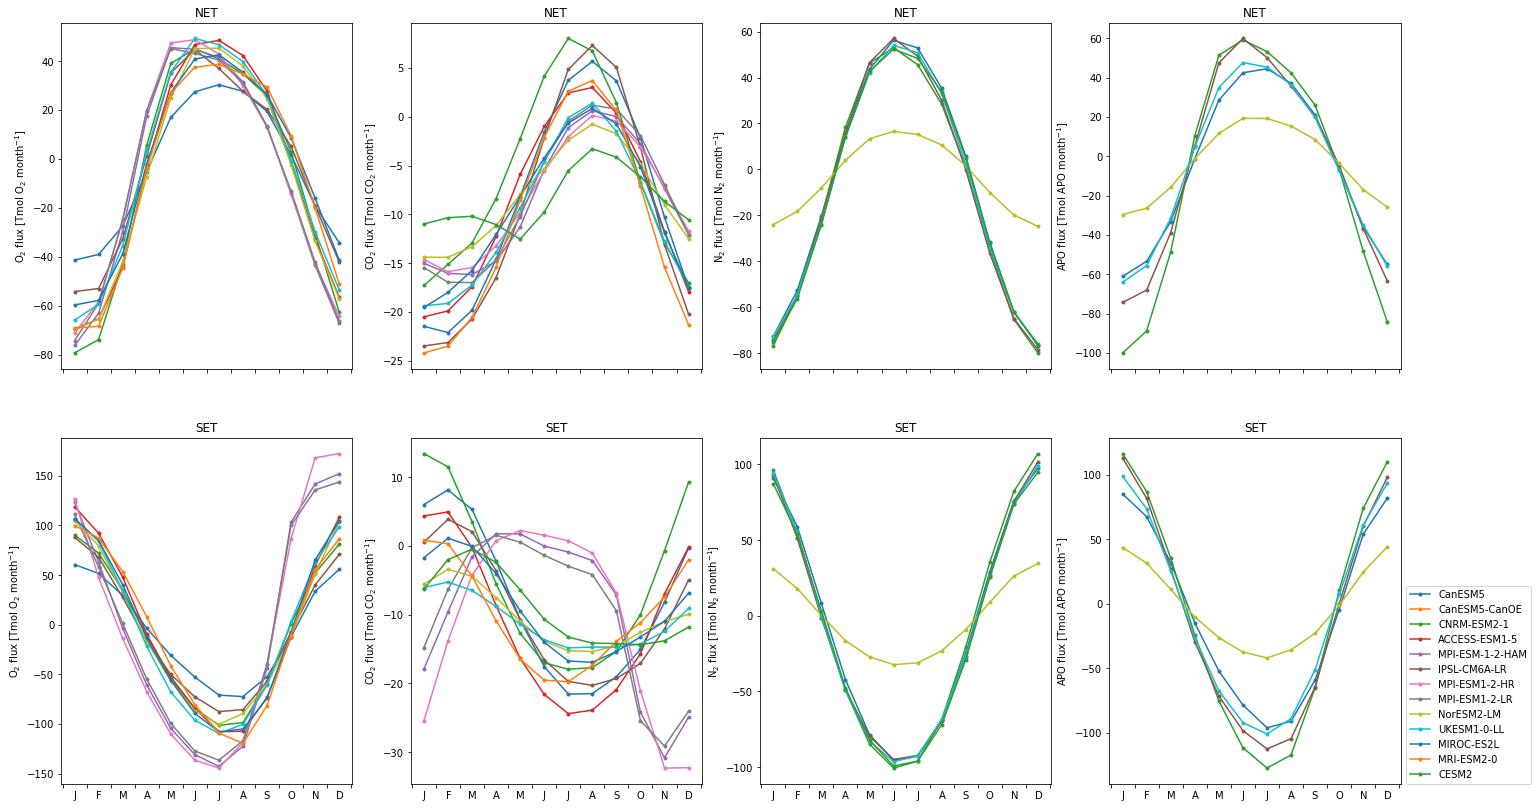

In [113]:
variable_ids = ['fgo2','fgco2','fgn2','fgapo']
plot4var2reg(variable_ids)

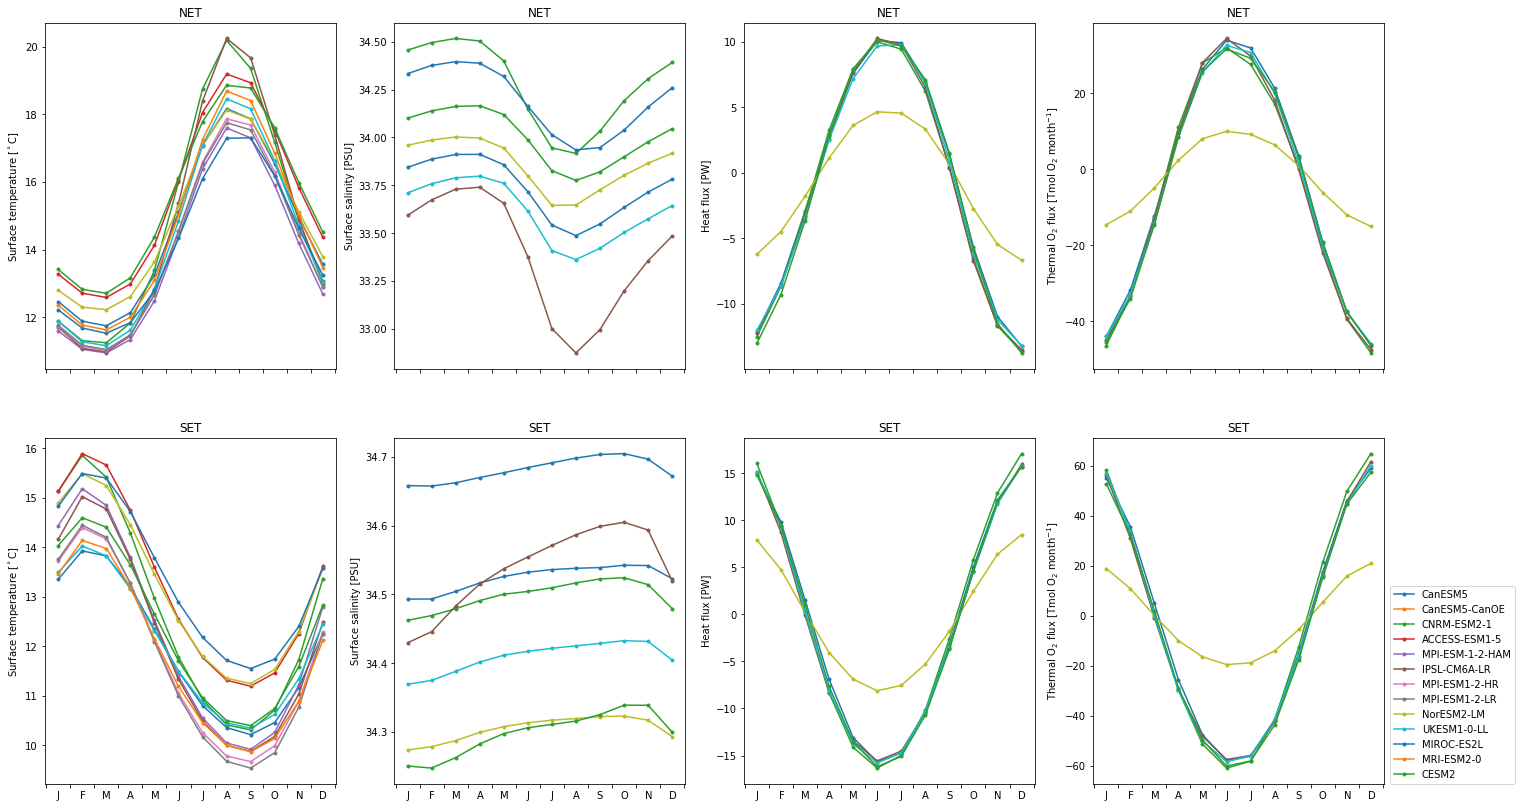

In [114]:
variable_ids = [ 'tos', 'sos', 'hfds','fgo2_thermal' ]
plot4var2reg(variable_ids)

KeyError: 'long_name'

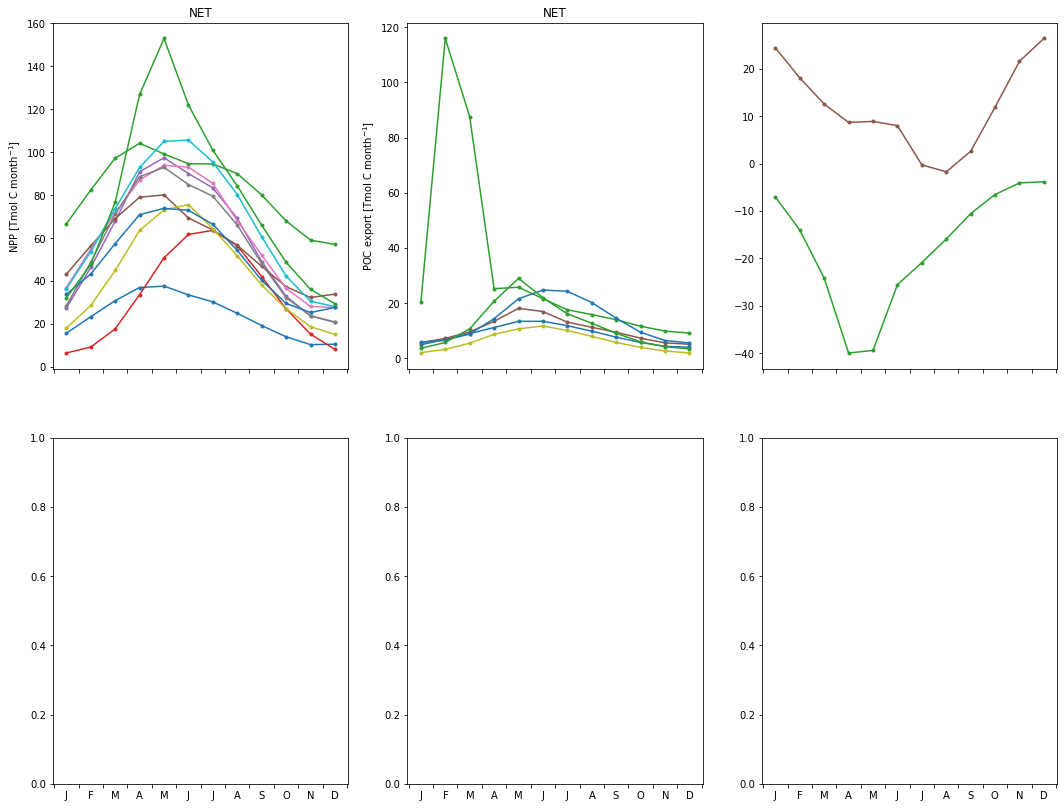

In [115]:
variable_ids = [ 'intpp', 'epc100', 'fbddtdic']
plot4var2reg(variable_ids)

## Test SNO calculations

In [94]:
# defining SNO here as the seasonal component of the O2 (or APO for SNOapo) flux
# specifically the integral of positive flux values after subtracting the annual mean
# (or the amplitude of the time-integrated flux cycle)
# this is to match the observed APO cycle in the atmosphere which has an arbitrary mean (i.e. it is agnostic to annual mean fluxes)

source_id='CanESM5'
region='SET'

# first remove the annual mean
ds['fgo2seas'] = ds['fgo2'].sel(source_id=source_id, region=region)-ds['fgo2'].sel(source_id=source_id, region=region).mean()

# then sum positive values
ds['sno']=sum(x for x in ds['fgo2seas'] if x > 0)
ds['sno'].values # 259.56

array(259.5581913)

In [97]:
# alternately calculate time integral
ds['fgo2cum'] = ds['fgo2seas'].cumsum()
# then find the amplitude
ds['sno'] = ds['fgo2cum'].max() - ds['fgo2cum'].min()
ds['sno'].values # 259.56

array(259.5581913)

In [96]:
# get a slightly different value if we interpolate to daily resolution first
tmp=np.interp(np.arange(0,366)/365*12,ds['fgo2seas'].month-0.5,ds['fgo2seas'],period=12)
sum(x for x in tmp if x > 0)*12/365 # 257.90

257.89942612370066

In [ ]:
### now just need to figure out how to loop through models and combine into a dataarray with same dimensions

for source_id in ds.source_id.values:

    for region in ds.region.values:   

# also calculate annual mean and seasonal amplitude of intpp, epc100, and fbddtdic

In [98]:
# list all models in catalog
cat.df.source_id.unique()

array(['BCC-ESM1', 'CNRM-ESM2-1', 'MPI-ESM-1-2-HAM', 'MIROC6',
       'MRI-ESM2-0', 'CESM2-WACCM', 'CESM2', 'NorESM2-LM', 'UKESM1-0-LL',
       'GFDL-ESM4', 'BCC-CSM2-MR', 'CanESM5', 'GISS-E2-1-G', 'TaiESM1',
       'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'CAMS-CSM1-0', 'FGOALS-f3-L',
       'FGOALS-g3', 'IITM-ESM', 'CanESM5-CanOE', 'CMCC-CM2-HR4',
       'CMCC-CM2-SR5', 'CNRM-CM6-1-HR', 'CNRM-CM6-1', 'ACCESS-CM2',
       'ACCESS-ESM1-5', 'E3SM-1-0', 'EC-Earth3-AerChem', 'EC-Earth3-CC',
       'EC-Earth3-LR', 'EC-Earth3-Veg-LR', 'EC-Earth3-Veg', 'EC-Earth3',
       'FIO-ESM-2-0', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR',
       'KIOST-ESM', 'MIROC-ES2L', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM',
       'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'GISS-E2-1-G-CC', 'GISS-E2-1-H',
       'CESM2-FV2', 'CESM2-WACCM-FV2', 'NorCPM1', 'NorESM1-F',
       'NorESM2-MM', 'KACE-1-0-G', 'GFDL-AM4', 'GFDL-CM4', 'NESM3',
       'SAM0-UNICON', 'CIESM', 'MCM-UA-1-0', 'CESM1-1-CAM5-CMIP5',
       'FGOALS-f3-H', 'CMCC-CM2-

In [99]:
# list all models that include historical Omon fgo2
tmp = cat.search(experiment_id='historical', table_id='Omon', grid_label='gn', variable_id='fgo2')
tmp.df.source_id.unique()

array(['CanESM5', 'CNRM-ESM2-1', 'ACCESS-ESM1-5', 'MPI-ESM-1-2-HAM',
       'IPSL-CM6A-LR', 'MIROC-ES2L', 'UKESM1-0-LL', 'MPI-ESM1-2-HR',
       'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorCPM1', 'NorESM2-LM'],
      dtype=object)